# Speech Emotion Recognition

**Importing Libraries**

In [1]:
import IPython
import librosa
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pathlib import Path
from PIL import Image
import random
import seaborn as sns
import scipy.io

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Conv1D, MaxPooling1D, Flatten, BatchNormalization
from keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Reshape
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import LSTM
from keras_self_attention import SeqSelfAttention

%matplotlib inline

**Utility Functions**

In [2]:
def find_min_list_len(list_of_lists):
    return np.min([len(i) for i in list_of_lists])

In [3]:
def find_max_list_len(list_of_lists):
    return np.max([len(i) for i in list_of_lists])

In [4]:
def return_random_audio_sample(df, label):
    return df.query(f"label == {label}").sample(n=1).index[0]

In [5]:
esd_path = Path('C:/Users/Admin/Documents/GitHub/msba265-finalstorage/Models/Audio/speech emotion model/Model testing 2/data/ESD')
X = list(esd_path.glob(r'**/*.wav'))
y = [file.parent.name for file in X]

In [6]:
df = pd.DataFrame({'path': X, 'label': y})
df

,path,label
0,C:\Users\Admin\Documents\GitHub\msba265-finals...,Angry
1,C:\Users\Admin\Documents\GitHub\msba265-finals...,Angry
2,C:\Users\Admin\Documents\GitHub\msba265-finals...,Angry
3,C:\Users\Admin\Documents\GitHub\msba265-finals...,Angry
4,C:\Users\Admin\Documents\GitHub\msba265-finals...,Angry
...,...,...
12245,C:\Users\Admin\Documents\GitHub\msba265-finals...,Surprise
12246,C:\Users\Admin\Documents\GitHub\msba265-finals...,Surprise
12247,C:\Users\Admin\Documents\GitHub\msba265-finals...,Surprise
12248,C:\Users\Admin\Documents\GitHub\msba265-finals...,Surprise


In [7]:
set(y)

{'Angry', 'Happy', 'Neutral', 'Sadness', 'Surprise'}

In [8]:
df['label'].value_counts()

label
Angry       2450
Happy       2450
Neutral     2450
Sadness     2450
Surprise    2450
Name: count, dtype: int64

**Sample for Anger**

In [9]:
IPython.display.Audio(df['path'][0])

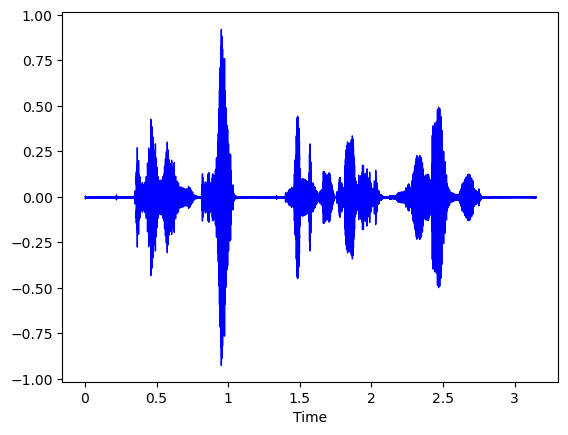

In [10]:
anger_sample = librosa.load(df['path'][0])[0]
librosa.display.waveshow(anger_sample, color="blue")

### Preparing Dataset

**Loading Audio into DataFrame**

In [11]:
X = []
audio_sampling = []
length = []
audio_arrays = []

for i in df['path']:
    x, sr = librosa.load(i, sr=44100)
    X.append(x)
    audio_sampling.append(sr)
    length.append(len(x))
    audio_arrays.append(x)
    
X = np.array(X, dtype='object')

**Transforming Labels**

In [12]:
le = LabelEncoder()
y = utils.to_categorical(le.fit_transform(y))
y

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]])

In [13]:
le_name_mapping = dict(zip(le.classes_, utils.to_categorical(le.transform(le.classes_))))
le_name_mapping

{'Angry': array([1., 0., 0., 0., 0.]),
 'Happy': array([0., 1., 0., 0., 0.]),
 'Neutral': array([0., 0., 1., 0., 0.]),
 'Sadness': array([0., 0., 0., 1., 0.]),
 'Surprise': array([0., 0., 0., 0., 1.])}

**Splitting into training, validation and test sets**

In [14]:
_, _, _, _, indices_train_val, indices_test = train_test_split(X, y, np.arange(len(X)), test_size=0.3, random_state=42, stratify=y)
_, _, _, _, indices_train, indices_val = train_test_split(X[indices_train_val], y[indices_train_val], indices_train_val, test_size=0.05, random_state=42, stratify=y[indices_train_val])

In [15]:
len(indices_train)

8146

In [16]:
len(indices_val)

429

In [17]:
len(indices_test)

3675

**Split on Audio Data**

In [18]:
X_train = X[indices_train]
X_val = X[indices_val]
X_test = X[indices_test]

**Split on Label Data**

In [19]:
y_train = y[indices_train]
y_val = y[indices_val]
y_test = y[indices_test]

### Data Augmentation

In [20]:
def awgn(data):
    noise_amp = 0.055 * np.random.uniform() * np.amax(data)
    data += noise_amp * np.random.normal(size=data.shape[0])
    return data

In [21]:
def pitch(data, sr=44100, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sr=sr, n_steps=1/pitch_factor)

In [22]:
def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate=rate)

In [23]:
def time_shift(data, sr=44100, shift_limit=1):
    shift_amt = int(random.random() * shift_limit * len(data))
    return np.roll(data, shift_amt)

In [24]:
def data_augment(X, y, aug_techniques=(awgn, pitch, time_shift)):
    awgn, pitch, time_shift = aug_techniques
    X_aug = []
    y_aug = []
    
    for i in range(len(X)):
        # Adding Original data
        X_aug.append(X[i])
        y_aug.append(y[i])
        
        # Adding AWGN and Time Shift
        X_aug.append(awgn(time_shift(X[i])))
        y_aug.append(y[i])
        
        # Applying Pitch and Time Shift
        X_aug.append(pitch(time_shift(X[i])))
        y_aug.append(y[i])
        
    
    X_aug = np.array(X_aug, dtype='object')
    y_aug = np.array(y_aug)
    
    return X_aug, y_aug

In [25]:
X_aug_train, y_aug_train = data_augment(X_train, y_train)

In [26]:
X_aug_train.shape

(24438,)

In [27]:
y_aug_train.shape

(24438, 5)

### Mel Spectrogram

In [28]:
def mel_spectrogram(X, sr=44100, spec_shape=(128, 128)):
    X_mel = []
    for data in X:
        sgram = librosa.stft(data)
        sgram_mag, _ = librosa.magphase(sgram)
        mel_scale_sgram = librosa.feature.melspectrogram(S=sgram_mag, sr=sr)
        mel_sgram = librosa.amplitude_to_db(mel_scale_sgram, ref=np.min)
        
        img = Image.fromarray(mel_sgram)
        img = np.asarray(img.resize(spec_shape, resample=Image.LANCZOS))
        
        X_mel.append(img)
    
    return np.array(X_mel)

_Without Augmentation_

In [29]:
X_f_train = mel_spectrogram(X_train)

In [30]:
X_f_val = mel_spectrogram(X_val)

In [31]:
X_f_test = mel_spectrogram(X_test)

_With Augmentation_

In [33]:
X_aug_f_train = mel_spectrogram(X_aug_train)

MemoryError: Unable to allocate 1.49 GiB for an array with shape (24438, 128, 128) and data type float32

**Callbacks**

In [34]:
def lr_scheduler(epoch, lr):
    if epoch % 5 == 0 and epoch > 0:
        lr /= 3
    return lr

lrs = LearningRateScheduler(lr_scheduler)
es = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1)

**Model Definition and Training**

**This is a modified implementation of:**

[Zhao, Jianfeng & Mao, Xia & Chen, Lijiang. (2019). Speech emotion recognition using deep 1D & 2D CNN LSTM networks. Biomedical Signal Processing and Control. 47. 312-323. 10.1016/j.bspc.2018.08.035.](https://www.sciencedirect.com/science/article/abs/pii/S1746809418302337)

### Frequency Domain

In [35]:
def model_2d(input_shape):
    # Define the model architecture
    model = tf.keras.Sequential()
    
    # Add the layers
    # LFLB1
    model.add(layers.Conv2D(64, (3, 3), strides=(1,1), padding='same', input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('elu'))
    model.add(layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    
    # LFLB2
    model.add(layers.Conv2D(64, (3, 3), strides=(1,1), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('elu'))
    model.add(layers.MaxPooling2D(pool_size=(4,4), strides=(4,4)))
    
    # LFLB3
    model.add(layers.Conv2D(128, (3, 3), strides=(1,1), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('elu'))
    model.add(layers.MaxPooling2D(pool_size=(4,4), strides=(4,4)))
    
    # LFLB4
    model.add(layers.Conv2D(128, (3, 3), strides=(1,1), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('elu'))
    model.add(layers.MaxPooling2D(pool_size=(4,4), strides=(4,4)))
    
    #LSTM
    model.add(layers.TimeDistributed(Flatten()))
    model.add(LSTM(units=64, return_sequences=True))
    model.add(SeqSelfAttention(attention_activation='tanh'))
    model.add(LSTM(units=64, return_sequences=False))
    
    #FC
    model.add(Dense(units=5, activation='softmax'))

    return model

_Without Augmentation_

In [36]:
model_f = model_2d((128, 128, 1))

model_f.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss="categorical_crossentropy",
              metrics=["accuracy"])
model_f.summary()

c:\Users\Admin\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 4, 4, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 4, 4, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 1, 128)         │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 1, 64)          │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ seq_self_attention              │ (None, 1, 64)          │         4,161 │
│ (SeqSelfAttention)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 347,462 (1.33 MB)

 Trainable params: 346,694 (1.32 MB)

 Non-trainable params: 768 (3.00 KB)

In [37]:
history_f = model_f.fit(X_f_train,
                      y_train,
                      batch_size=16,
                      epochs=20,
                      validation_data=(X_f_val, y_val),
                      callbacks=[
                          es,
                          ModelCheckpoint('esd_model_f.keras', monitor='val_loss', save_best_only=True, verbose=1),
                          lrs
                      ]
)

Epoch 1/20
510/510 ━━━━━━━━━━━━━━━━━━━━ 0s 789ms/step - accuracy: 0.4113 - loss: 1.4208
Epoch 1: val_loss improved from inf to 0.98234, saving model to esd_model_f.keras
510/510 ━━━━━━━━━━━━━━━━━━━━ 421s 804ms/step - accuracy: 0.4115 - loss: 1.4204 - val_accuracy: 0.6224 - val_loss: 0.9823 - learning_rate: 1.0000e-04
Epoch 2/20
510/510 ━━━━━━━━━━━━━━━━━━━━ 0s 772ms/step - accuracy: 0.7888 - loss: 0.6863
Epoch 2: val_loss improved from 0.98234 to 0.76165, saving model to esd_model_f.keras
510/510 ━━━━━━━━━━━━━━━━━━━━ 400s 784ms/step - accuracy: 0.7888 - loss: 0.6862 - val_accuracy: 0.7203 - val_loss: 0.7616 - learning_rate: 1.0000e-04
Epoch 3/20
510/510 ━━━━━━━━━━━━━━━━━━━━ 0s 774ms/step - accuracy: 0.8840 - loss: 0.3748
Epoch 3: val_loss improved from 0.76165 to 0.36676, saving model to esd_model_f.keras
510/510 ━━━━━━━━━━━━━━━━━━━━ 401s 787ms/step - accuracy: 0.8840 - loss: 0.3748 - val_accuracy: 0.8555 - val_loss: 0.3668 - learning_rate: 1.0000e-04
Epoch 4/20
510/510 ━━━━━━━━━━━━━━━━

In [38]:
test_loss_f, test_acc_f = model_f.evaluate(X_f_test, y_test)

115/115 ━━━━━━━━━━━━━━━━━━━━ 40s 348ms/step - accuracy: 0.9236 - loss: 0.2059


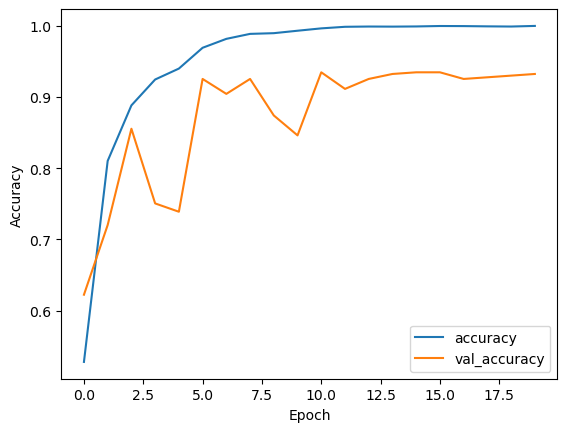

In [39]:
plt.plot(history_f.history['accuracy'], label='accuracy')
plt.plot(history_f.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

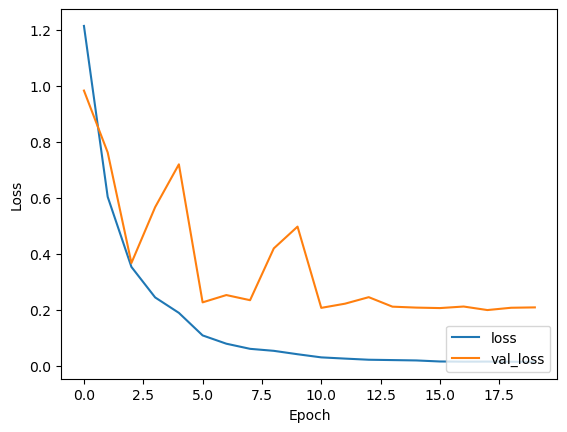

In [40]:
plt.plot(history_f.history['loss'], label='loss')
plt.plot(history_f.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')

### Frequency Domain

**_Without Augmentation_**

In [41]:
y_train_pred_f = model_f.predict(X_f_train)
y_val_pred_f = model_f.predict(X_f_val)
y_test_pred_f = model_f.predict(X_f_test)

255/255 ━━━━━━━━━━━━━━━━━━━━ 90s 350ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 344ms/step
115/115 ━━━━━━━━━━━━━━━━━━━━ 39s 339ms/step


**Training**

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1629
           1       1.00      1.00      1.00      1629
           2       1.00      1.00      1.00      1629
           3       1.00      1.00      1.00      1630
           4       1.00      1.00      1.00      1629

    accuracy                           1.00      8146
   macro avg       1.00      1.00      1.00      8146
weighted avg       1.00      1.00      1.00      8146



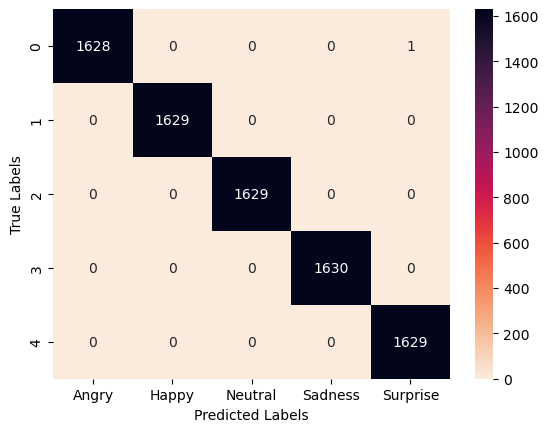

In [44]:
compare_performance(y_train, y_train_pred_f)

**Validation**

              precision    recall  f1-score   support

           0       0.90      0.93      0.91        86
           1       0.90      0.91      0.90        86
           2       0.95      0.90      0.92        86
           3       0.94      0.99      0.97        85
           4       0.95      0.92      0.93        86

    accuracy                           0.93       429
   macro avg       0.93      0.93      0.93       429
weighted avg       0.93      0.93      0.93       429



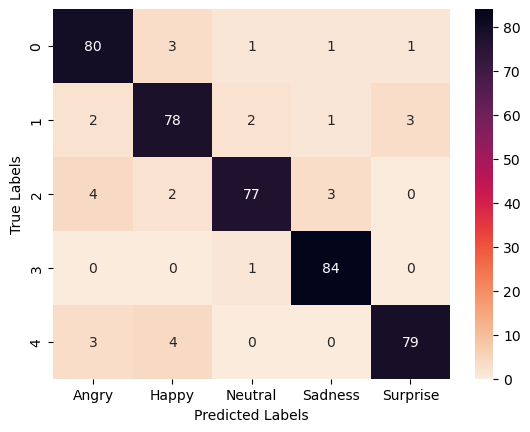

In [45]:
compare_performance(y_val, y_val_pred_f)

**Test**

              precision    recall  f1-score   support

           0       0.92      0.93      0.93       735
           1       0.91      0.88      0.89       735
           2       0.93      0.94      0.93       735
           3       0.97      0.95      0.96       735
           4       0.91      0.94      0.93       735

    accuracy                           0.93      3675
   macro avg       0.93      0.93      0.93      3675
weighted avg       0.93      0.93      0.93      3675



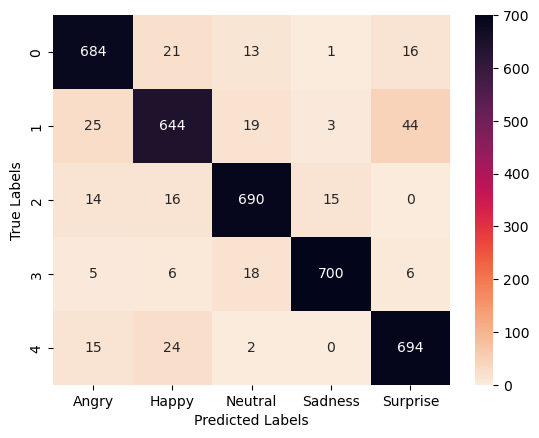

In [46]:
compare_performance(y_test, y_test_pred_f)